In [1]:
# Import libraries
%load_ext autoreload
%autoreload 2

import sys
import os
import shap
import json

# Get the parent directory (project root)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Now you can import from config
from config import config
from workflows import generate_data as gd
import prompts.prompt_generator as pg
from evaluation import judge

from clients.azure_openai_client import *

In [2]:
# Initialize the mock client
# mock_client = MockAzureClient()
azure_client = get_azure_client(use_mock=True)

# Call get_response without specifying model_name
response1 = azure_client.get_response(prompt="Explain the risk score.")
print("Response 1:\n", response1)

# Call get_response with a model_name containing "judge"
response2 = azure_client.get_response(
    prompt="Evaluate explanation clarity.",
    model_name="RiskJudgeModel-v1"
)
print("\nResponse 2:\n", response2)

🧪 Mock Azure Client initialized. No actual API calls will be made.
Response 1:
 This entity has a high risk score of 85% primarily due to three factors: a high number of inbound wires, significant exposure to high-risk countries, and a central position in transaction networks. Each of these increases the risk profile significantly.

Response 2:
 Clarity: 2/5
Conciseness: 5/5
Completeness: 3/5
Complete evaluation provided.


In [3]:
feature_lib = gd.create_realistic_aml_feature_library()

input_data_path = "../data/input/structured_aml_dataset.json"
df_structured = gd.generate_structured_shap_dataset(feature_lib, n_entities=100, output_path=input_data_path)

✅ Structured dataset saved to ../data/input/structured_aml_dataset.json


In [4]:
feature_lib

feature_name  \
0                   wirein_ct   
1                  wireout_ct   
2                  wirein_amt   
3                 wireout_amt   
4                 avg_txn_amt   
5   high_risk_country_txn_pct   
6               acct_age_days   
7             num_sar_reports   
8              login_freq_30d   
9         geo_diversity_score   
10                  wirein_ct   
11                 wireout_ct   
12                 wirein_amt   
13                wireout_amt   
14                avg_txn_amt   

                                          description  
0                 Number of wire inbound transactions  
1                Number of wire outbound transactions  
2                           Total inbound wire amount  
3                          Total outbound wire amount  
4                          Average transaction amount  
5   Percentage of transactions with high-risk coun...  
6                                 Account age in days  
7                         Number of SAR reports filed  
8                 Login frequency in the past 30 days  
9            Number of unique countries accessed from  
10                Number of wire inbound transactions  
11               Number of wire outbound transactions  
12                          Total inbound wire amount  
13                         Total outbound wire amount  
14                         Average transaction amount

In [5]:
df_structured

entity_id  risk_score                                           features
0           1    0.325256  {'wirein_ct': {'feature_value': 16, 'shap_valu...
1           2    0.000000  {'wirein_ct': {'feature_value': 7, 'shap_value...
2           3    0.489668  {'wirein_ct': {'feature_value': 19, 'shap_valu...
3           4    0.285840  {'wirein_ct': {'feature_value': 8, 'shap_value...
4           5    0.106975  {'wirein_ct': {'feature_value': 7, 'shap_value...
..        ...         ...                                                ...
95         96    0.000000  {'wirein_ct': {'feature_value': 9, 'shap_value...
96         97    0.062987  {'wirein_ct': {'feature_value': 12, 'shap_valu...
97         98    0.254120  {'wirein_ct': {'feature_value': 13, 'shap_valu...
98         99    0.189720  {'wirein_ct': {'feature_value': 8, 'shap_value...
99        100    0.182482  {'wirein_ct': {'feature_value': 10, 'shap_valu...

[100 rows x 3 columns]

In [6]:
# Load structured dataset
with open(input_data_path, "r") as f:
    entity_data_list = [json.loads(line) for line in f]

In [7]:
len(entity_data_list)

100

In [8]:
top_n = 3

# Add prompt column
# df_with_prompts = gd.add_prompt_column(entity_data_list, feature_library_df, top_n=5)
df_with_prompts = gd.generate_rotating_feature_prompts(
    entity_data_list, feature_lib,
    top_n = top_n
)
# gd.add_prompt_to_entity_json(entity_data_list, feature_library_df, top_n=top_n, selected_features=seg)

output_data_path = "../data/output/entities_with_prompts.json"
gd.save_entities_to_json(df_with_prompts, output_data_path)

✅ Entities saved to ../data/output/entities_with_prompts.json


In [9]:
feature_lib['feature_name']

0                     wirein_ct
1                    wireout_ct
2                    wirein_amt
3                   wireout_amt
4                   avg_txn_amt
5     high_risk_country_txn_pct
6                 acct_age_days
7               num_sar_reports
8                login_freq_30d
9           geo_diversity_score
10                    wirein_ct
11                   wireout_ct
12                   wirein_amt
13                  wireout_amt
14                  avg_txn_amt
Name: feature_name, dtype: object

In [10]:
df_with_prompts[0]['prompt']

'You are a risk model explanation assistant. Given a risk score and a list of features with their descriptions and contributions, generate a clear, concise narrative explaining the risk score for entity ID 1.\n\nEntity ID: 1\nRisk Score: 33%\nTop Features and Contributions:\n- wireout_ct (Number of wire outbound transactions): 5.4% contribution\n- wireout_ct (Number of wire outbound transactions): 5.4% contribution\n- wirein_amt (Total inbound wire amount): 5.2% contribution\n\nPlease produce a narrative that:\n- Starts with the risk score\n- Explains each feature’s contribution in plain language\n- Highlights why each feature might indicate a higher risk\n'

In [11]:
df_with_prompts[1]['prompt']

'You are a risk model explanation assistant. Given a risk score and a list of features with their descriptions and contributions, generate a clear, concise narrative explaining the risk score for entity ID 2.\n\nEntity ID: 2\nRisk Score: 0%\nTop Features and Contributions:\n- avg_txn_amt (Average transaction amount): 8.5% contribution\n- avg_txn_amt (Average transaction amount): 8.5% contribution\n- wireout_amt (Total outbound wire amount): 6.6% contribution\n\nPlease produce a narrative that:\n- Starts with the risk score\n- Explains each feature’s contribution in plain language\n- Highlights why each feature might indicate a higher risk\n'

In [12]:
# Load structured dataset
with open(output_data_path, "r") as f:
    entity_data_list = json.load(f)

In [13]:
feature_library_df = feature_lib

In [14]:
# output_data_path = "../data/output/entities_with_prompts.json"

updated_entities = gd.enrich_entities_with_llm_explanations(
    input_json_path="../data/output/entities_with_prompts.json",
    output_json_path="../data/output/entities_with_llm_explanations.json",
    feature_library_df=feature_library_df,
    azure_client=azure_client,
    top_n=top_n,
    log_every_n=25# New parameter for logging frequency
)

Processed entity 5/5
✅ Saved enriched entities with explanations to ../data/output/entities_with_llm_explanations.json


In [15]:
with open("../data/output/entities_with_llm_explanations.json", "r") as f:
    output = json.load(f)

In [16]:
enriched_entities = gd.enrich_and_evaluate_entities(
    input_json_path="../data/output/entities_with_llm_explanations.json",
    output_json_path="../data/output/entities_enriched_evaluated.json",
    feature_library_df=feature_library_df,
    azure_client=azure_client,
    judge_models=judge.MOCK_JUDGE_MODELS,
    top_n=top_n,
    log_every_n=25  # print progress every 3 entities
)

✅ Processed 5/5 entities
✅ Evaluations completed and saved to ../data/output/entities_enriched_evaluated.json


In [17]:
with open("../data/output/entities_enriched_evaluated.json", "r") as f:
    output = json.load(f)

In [18]:
entity_data_list = gd.update_mean_std_scores_in_json(
    input_json_path="../data/output/entities_enriched_evaluated.json",
    output_json_path="../data/output/entities_with_stats.json"
)

✅ Per-entity stats saved to: ../data/output/entities_with_stats.json


In [19]:
with open("../data/output/entities_with_stats.json", "r") as f:
    output = json.load(f)

Figure saved to: ../data/output/evaluation_scores.png


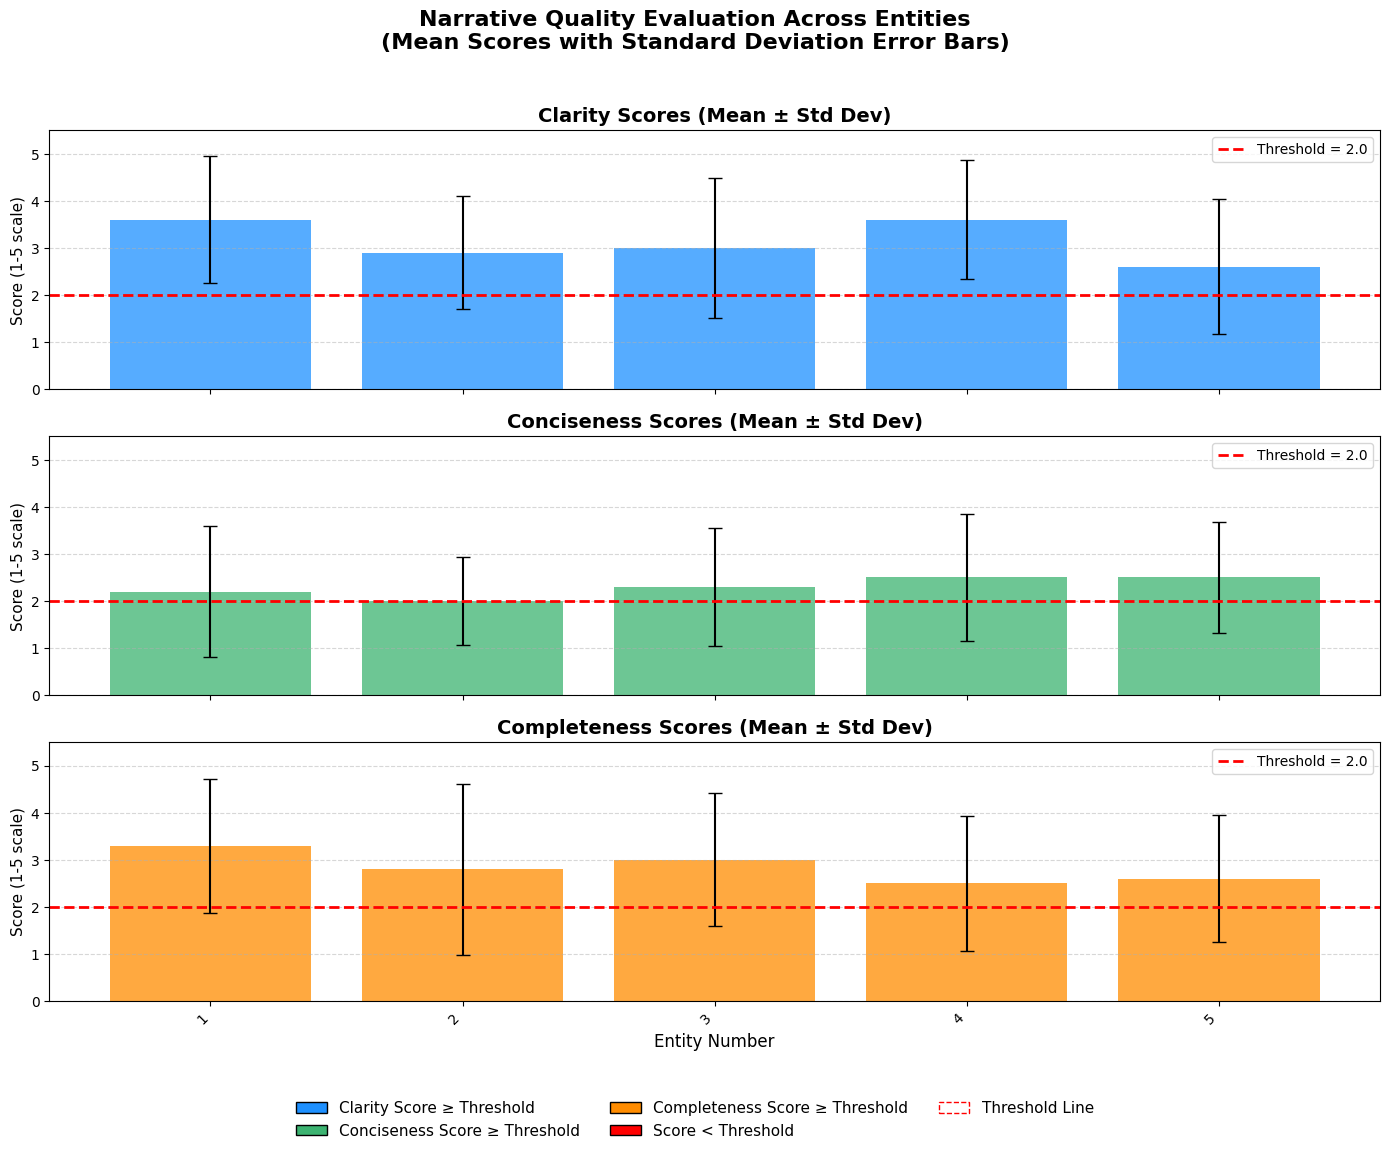

In [20]:
threshold = 2.0

gd.plot_entity_quality_stats_business(output, threshold=threshold, save_path="../data/output/evaluation_scores.png")

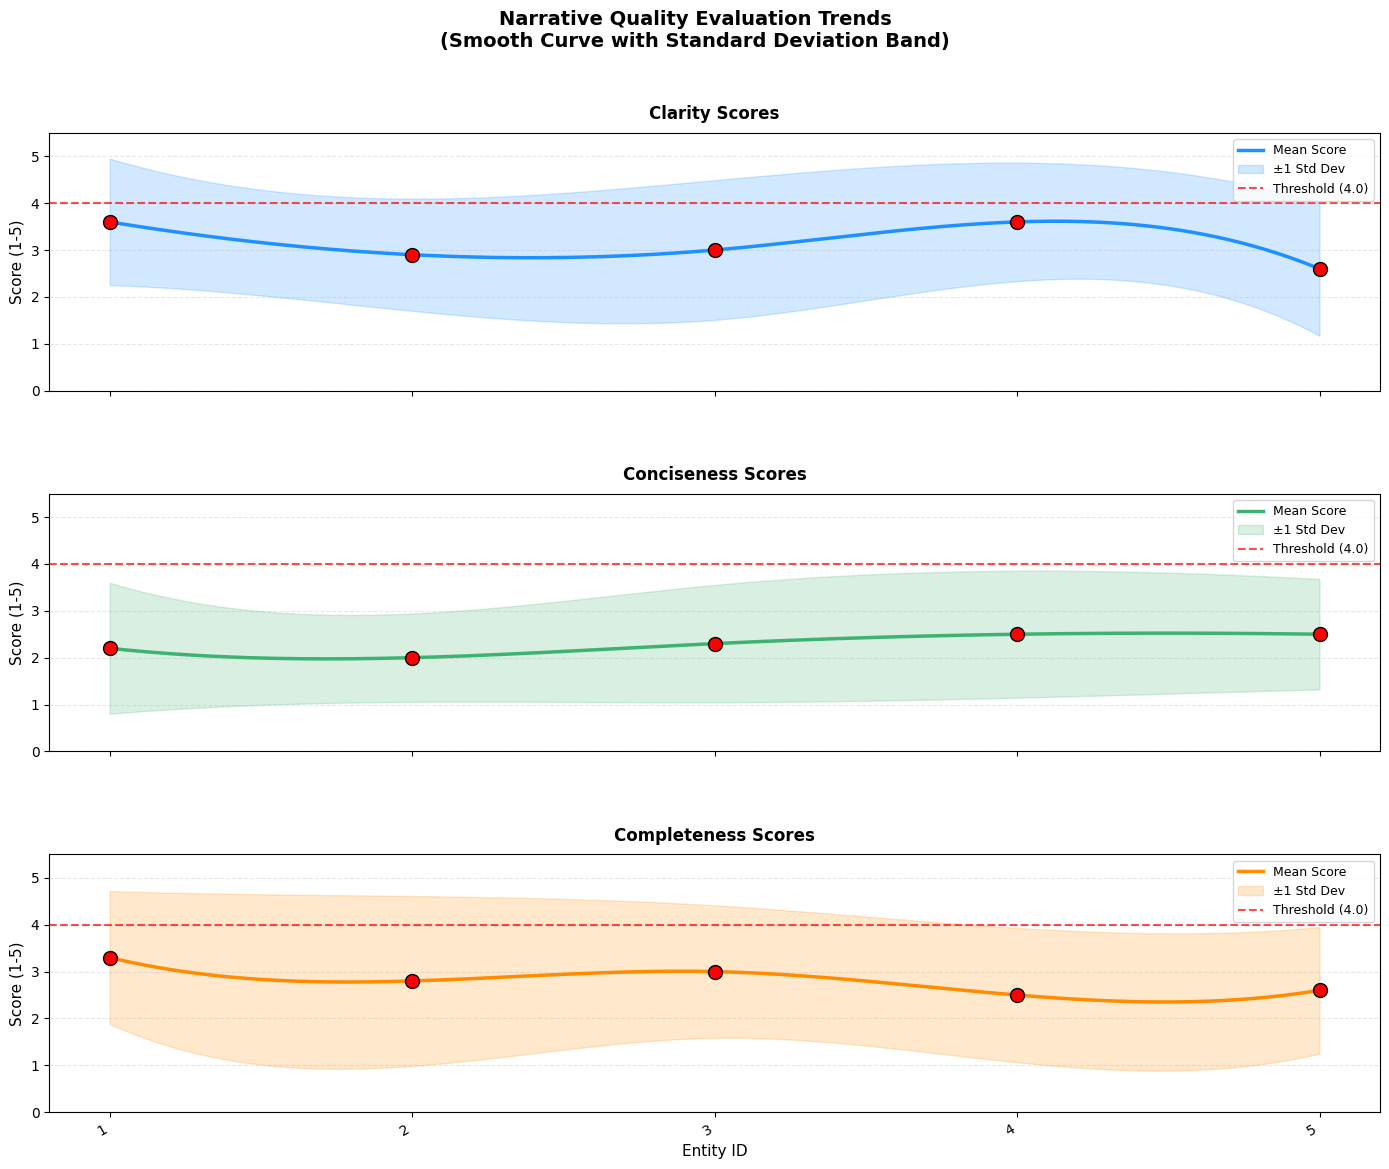

In [21]:
gd.plot_entity_quality_stats_business_curve(output, threshold=4.0, save_path=None)